### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, classification_report

from sklearn.preprocessing import  OneHotEncoder
import category_encoders as ce
from sklearn.decomposition import PCA

/tmp/ipykernel_3825/3043828360.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### Загрузка данных

In [2]:
X_test = np.load('data/X_test.npy')
X_train = np.load('data/X_train.npy')
y_train = pd.read_csv('data/y_train.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')
y_train = y_train['Class']
print(f'X_train shape:{X_train.shape}, X_test shape:{X_test.shape}, y_train shape:{y_train.shape}, sub shape:{sample_submission.shape}')

X_train shape:(165, 40, 60), X_test shape:(166, 40, 60), y_train shape:(165,), sub shape:(166, 2)


### Работа c данными(EDA)

**Описание данных**

X_train.npy и X_test.npy имеют следующие размерности (наблюдения, датчики, время);

y_train.csv содержит следующие классы:

|Кодировка жеста     |Расшифровка        ||Кодировка жеста     |Расшифровка        |
|--------------------|-------------------|----|--------------------|-------------------|
|"0"| разгиб жеста "grab"|*|"8" | сгиб мизинца|
|"1" | разгиб жеста "ok"|*|"9" | сгиб безымянного пальца|
|"2" | разгиб большого пальца|*|"10" | сгиб среднего пальца|
|"3" | разгиб указательного пальца|*|"11" | сгиб жеста "пистолет"|
|"4" | разгиб жеста "пистолет"|*|"12" | сгиб указательного пальца|
|"5" | разгиб среднего пальца|*|"13" | сгиб большого пальца|
|"6" | разгиб безымянного пальца|*|"14" | сгиб жеста "ok"|
|"7" | разгиб мизинца|*|"15" | сгиб жеста "grab"|

Проверим датасет на пропущенные значения

In [3]:
flag = False
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
        for k in range(X_train.shape[2]):
            if X_train[i][j][k] is np.nan:
                flag = True
print(f'Есть пропущенные значения? - {flag}')

Есть пропущенные значения? - False


Создадим два словаря жестов, чтобы в будущем проще было ориентироваться.

Первый словарь соотносит код жеста с описанием его выполнения.

Второй разделяет и записывает индекс наблюдения в каждый класс жеста.

In [4]:
# словарь перевода жестов с численного типа к строчному
sign_dict = {0:'разгиб жеста "grab"',1:'разгиб жеста "ok"',2:'разгиб большого пальца',3:'разгиб указательного пальца',
             4:'разгиб жеста "пистолет"',5:'разгиб среднего пальца',6:'разгиб безымянного пальца',
             7:'разгиб мизинца',8:'сгиб мизинца',9:'сгиб безымянного пальца',10:'сгиб среднего пальца',
             11:'сгиб жеста "пистолет"',12:'сгиб указательного пальца',13:'сгиб большого пальца',
             14:'сгиб жеста "ok"',15:'сгиб жеста "grab"'}

# создадим словарь жестов с номерами наблюдений в нашем датасете
dict_ind = {}
for i in range(y_train.shape[0]):
    dict_ind.setdefault(y_train.loc[i], []).append(i)


Для анализа данных создадим несколько функций

In [5]:
def show_sign_partly(sign: int, n_sensor: int) -> object:
    """выводит линейный график всех наблюдений данного жеста и датчика и
        возращает краткую информацию о конкретном датчике в конкретном жесте

    Args:
        sign (int): номер жеста
        n_sensor (int): номер датчика

    Returns:
        tuple[object, str]: линейный график всех наблюдений данного жеста и датчика, и
                        краткую информацию о конкретном датчике в конкретном жесте
    """
    examples = dict_ind[sign] 
    
    fig = plt.figure(figsize=(14, 4))
    min_list, max_list = [], []
    for ex in examples:
        min_list.append(X_train[ex][n_sensor - 1].min())
        max_list.append(X_train[ex][n_sensor - 1].max())
        
        line = sns.lineplot(x=list(range(60)), y=X_train[ex][n_sensor - 1], color='Green')
        line.set_title(f'Жест: {sign_dict[sign]}. Датчик №{n_sensor}')
    
    plt.xlim(0, 60)
    plt.ylim(0, 4096)   
    min_line = sns.lineplot(x=list(range(60)), y= [min(min_list)]* 60, label='min', color='black', ls='--')
    max_line = sns.lineplot(x=list(range(60)), y= [max(max_list)]* 60, label='max', color='red', ls='--')
    print(f'MIN: {min(min_list)} MAX: {max(max_list)} DIFF: {max(max_list) - min(min_list)}')
    
   
def show_sign_full(sign: int, value='all') -> object :
    """функция выводит линейный график всех сенсоров конкретного жеста

    Args:
        sign (int): номер жеста
        value (str, optional): сколько примеров жеста нужно вывести. Defaults to 'all'.

    Returns:
        object: линейный график
    """
    examples = dict_ind[sign] if value =='all' else np.random.choice(dict_ind[sign], value)
    if value == 'all':
        for ex in examples:
            fig = plt.figure(figsize=(10, 6))
            for i in range(40):
                line = sns.lineplot(x=list(range(60)), y=X_train[ex][i])
                line.set_title(f'Жест: {sign_dict[sign]}')
    
    else:
        for ex in examples:
            fig = plt.figure(figsize=(10, 6))
            for i in range(40):
                line = sns.lineplot(x=list(range(60)), y=X_train[ex][i])
                line.set_title(f'Жест: {sign_dict[sign]}')


def comprasion_sign(s_1: int, s_2: int) -> object:
    """функция позволяет сравниваить линейные графики сенсоров разных жестов

    Args:
        s_1 (int):первый жест для сравнения
        s_2 (int): второй жест для сравнения

    Returns:
        object: два линейных графика
    """
    s_1_ex = int(np.random.choice(dict_ind[s_1], 1))
    s_2_ex = int(np.random.choice(dict_ind[s_1], 1))

    
    fig, axes = plt.subplots(1, 2, figsize=(25, 6))
    for i in range(40):
        sign_1 = sns.lineplot(x=list(range(60)),y=X_train[s_1_ex][i], ax=axes[0])
        sign_1.set_title(f'Жест: {sign_dict[s_1]}', fontsize=15)
    for i in range(40):
        sign_2 = sns.lineplot(x=list(range(60)),y=X_train[s_2_ex][i], ax=axes[1])
        sign_2.set_title(f'Жест: {sign_dict[s_2]}', fontsize=15)
        
    plt.tight_layout()
    
def show_hist_kde(value: int, sensor: int) -> object:
    """функция показывает распределение показаний на конкретном наблюдении

    Args:
        value (int): начальный номер наблюдения 
        sensor (int): номер датчика

    Returns:
        object: возращает гистограмму с kde линией пяти наблюдений начиная с заданного value
    """
    sample = pd.DataFrame(X_train[value: value + 5, sensor,:]).T
        
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for i in range(5):
        hist = sns.histplot(data=sample, x=i, kde=True, ax=axes[i], bins=10)
        hist.set_xlabel(f'Наблюдение №{value + i} Датчик №{sensor}')
    fig.tight_layout()

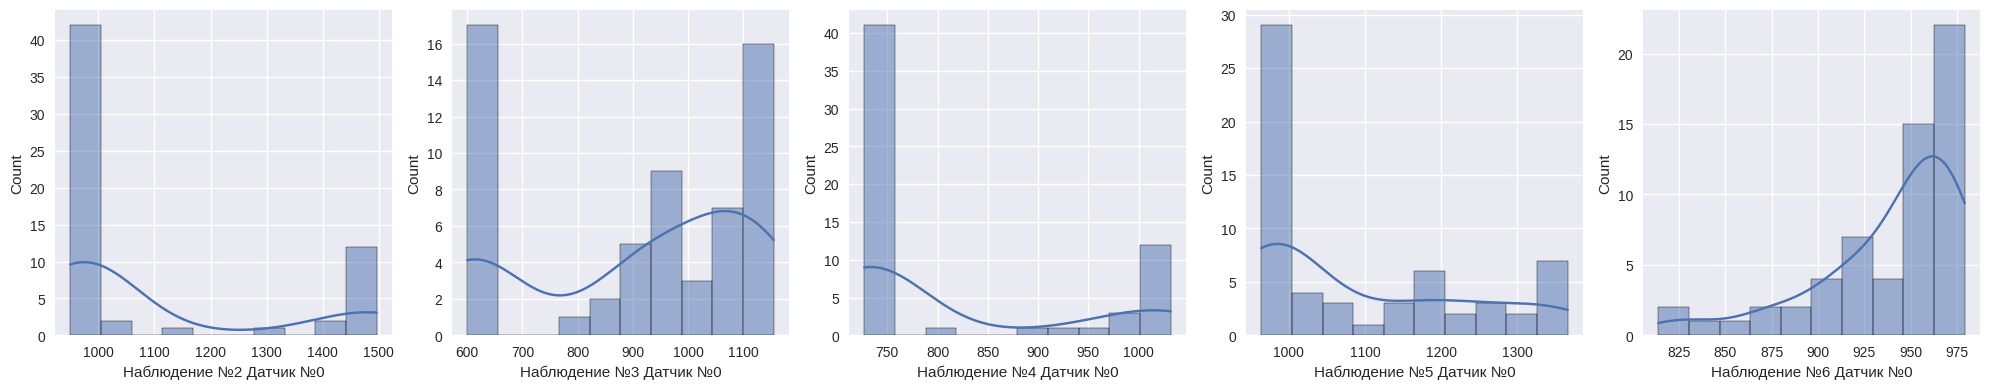

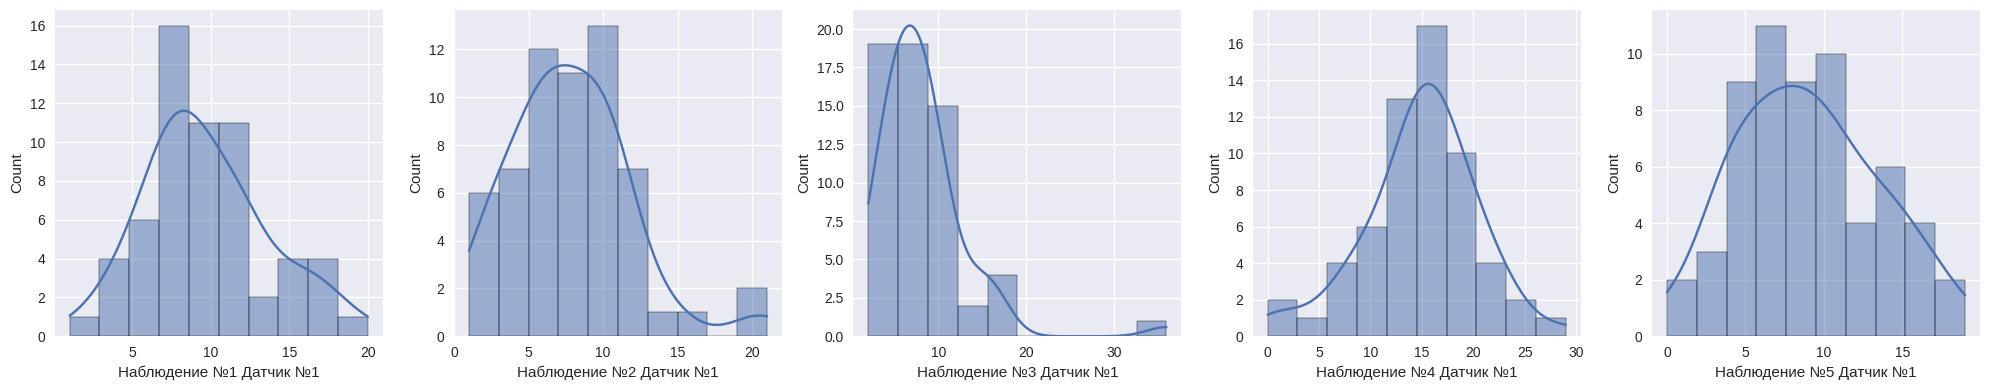

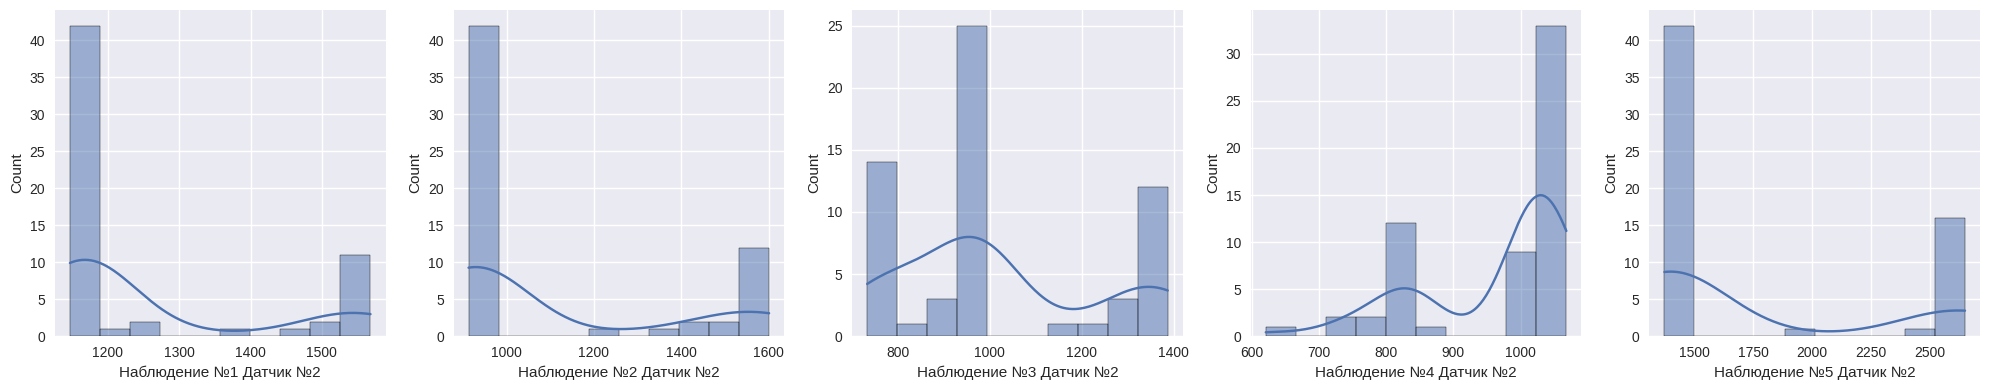

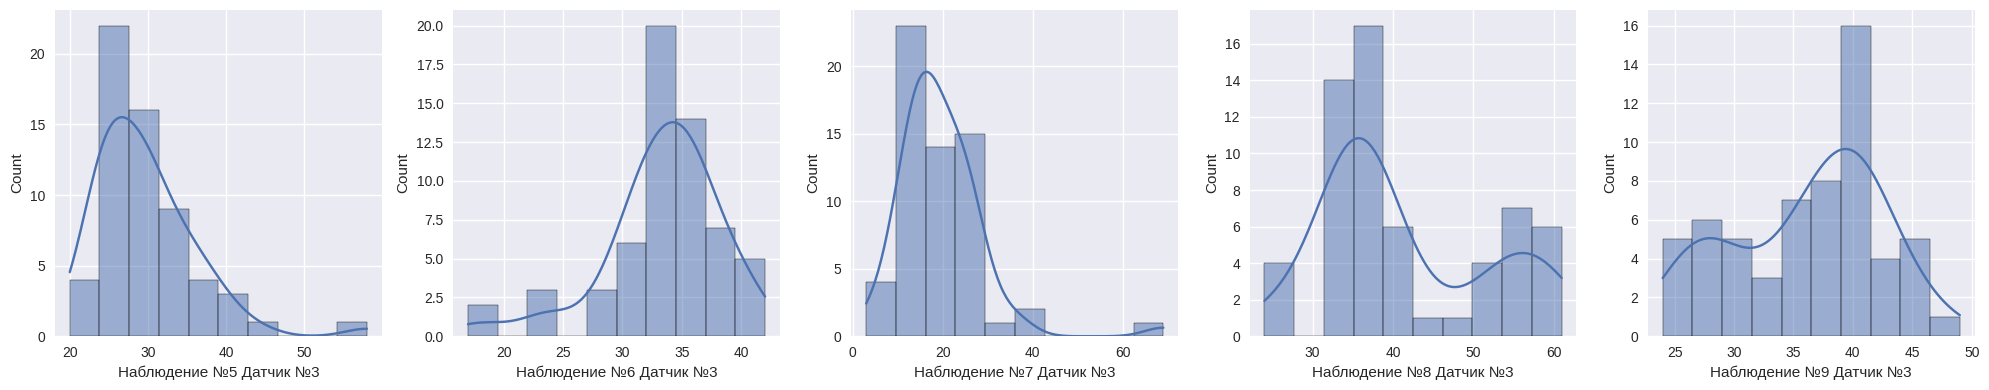

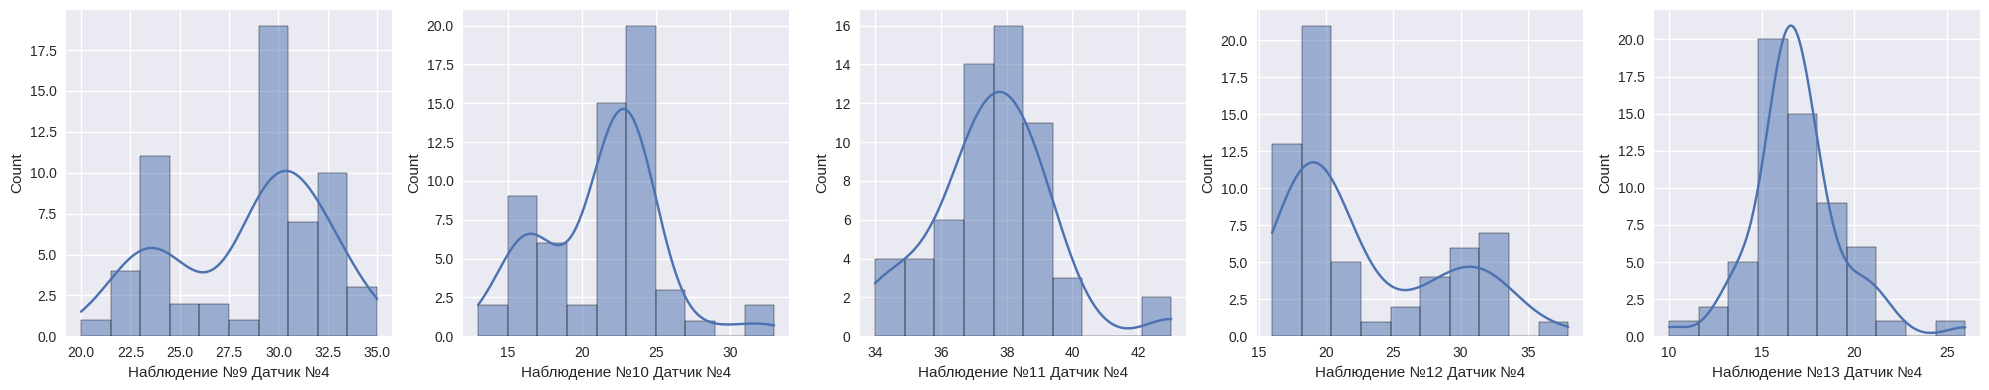

In [6]:
# Посмтрим на 5 разных датчиков в 5 наблюдений 
for i in range(5):
    show_hist_kde(np.random.randint(0, 10), i)

На гистограммах имеются:

1. Нормальное распределение показаний, что говорит о том что датчик не отработал и имеются шумы. (так же редко видны логнормальные распределения, что не особо важно)

2. Распределение с 2 вершинами, что говорит о четком сигнале при срабатывании

3. Встречаются не четкие распределения, которые вызваны дрейфом датчиков.

Взглянем на два противоположных жеста

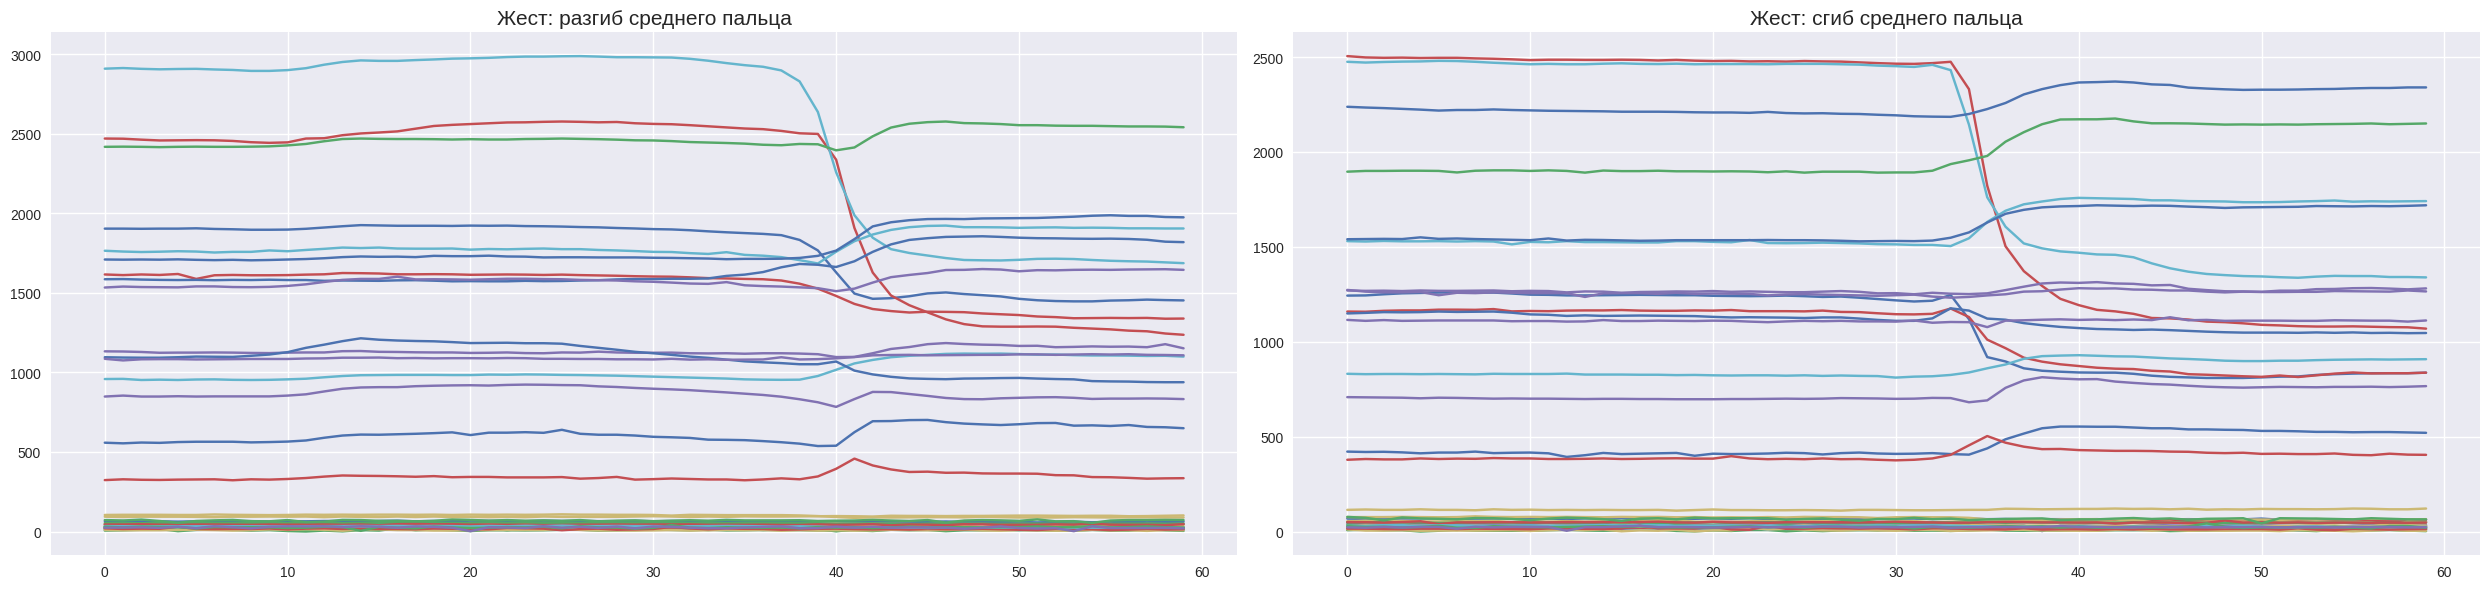

In [7]:
comprasion_sign(5, 10)

Видно противоположное направление и разная амлитуда у некоторых датчиков. Они скорее всего и будут являются ключевыми в предсказании жеста. Для этого мы поделим на классы динамику волн

Как видно на рисунках ниже, масштаб амплитуды датчиков очень большой. Поэтому,чтобы закодировать динамику сенсора, нам нужно точно подобрать герцовку направления движения волны.

MIN: 725.0 MAX: 1925.0 DIFF: 1200.0


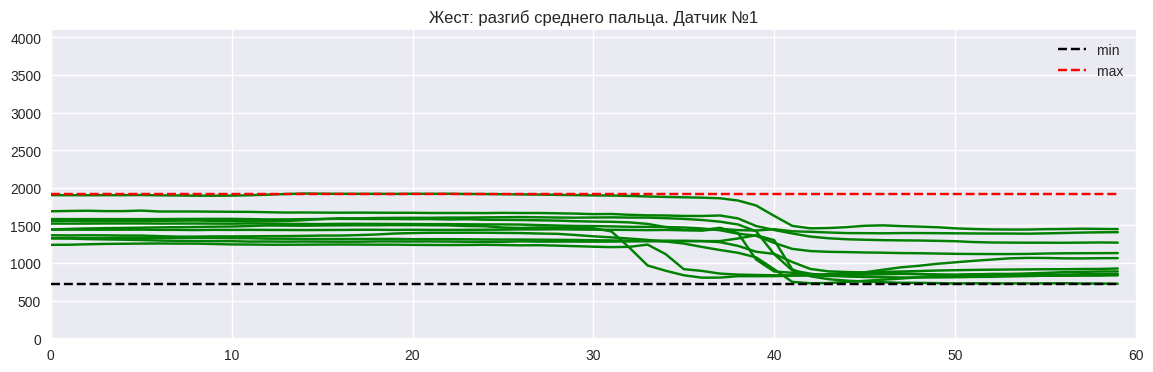

In [8]:
show_sign_partly(5, 1)

MIN: 687.0 MAX: 2703.0 DIFF: 2016.0


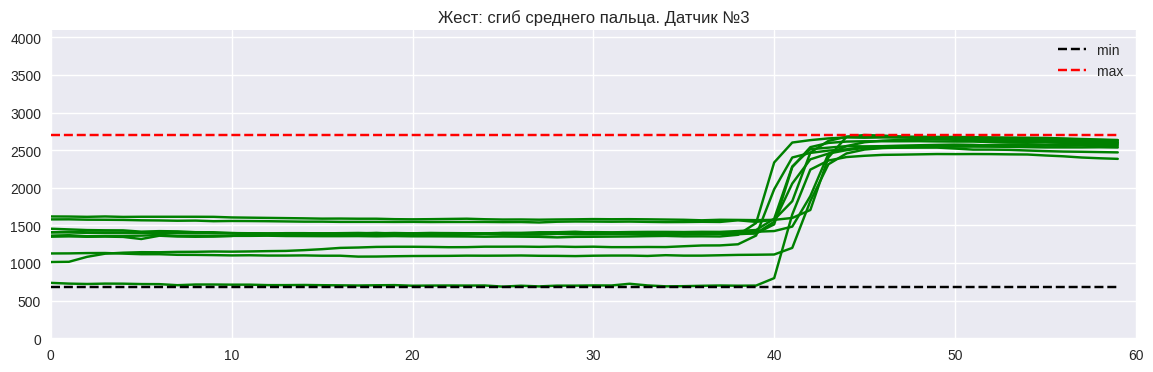

In [9]:
show_sign_partly(10, 3)

MIN: 910.0 MAX: 1832.0 DIFF: 922.0


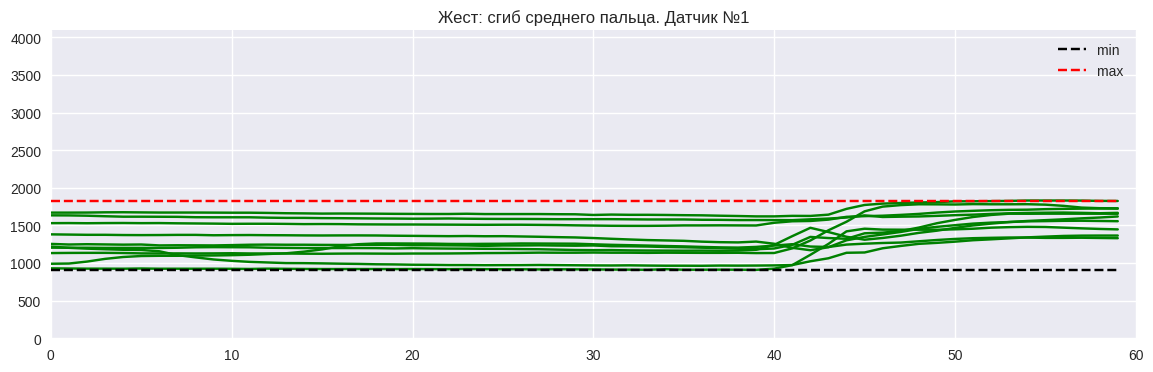

In [10]:
show_sign_partly(10, 1)

Также можно посмотреть на корреляцию значений, например 54-ого наблюдения

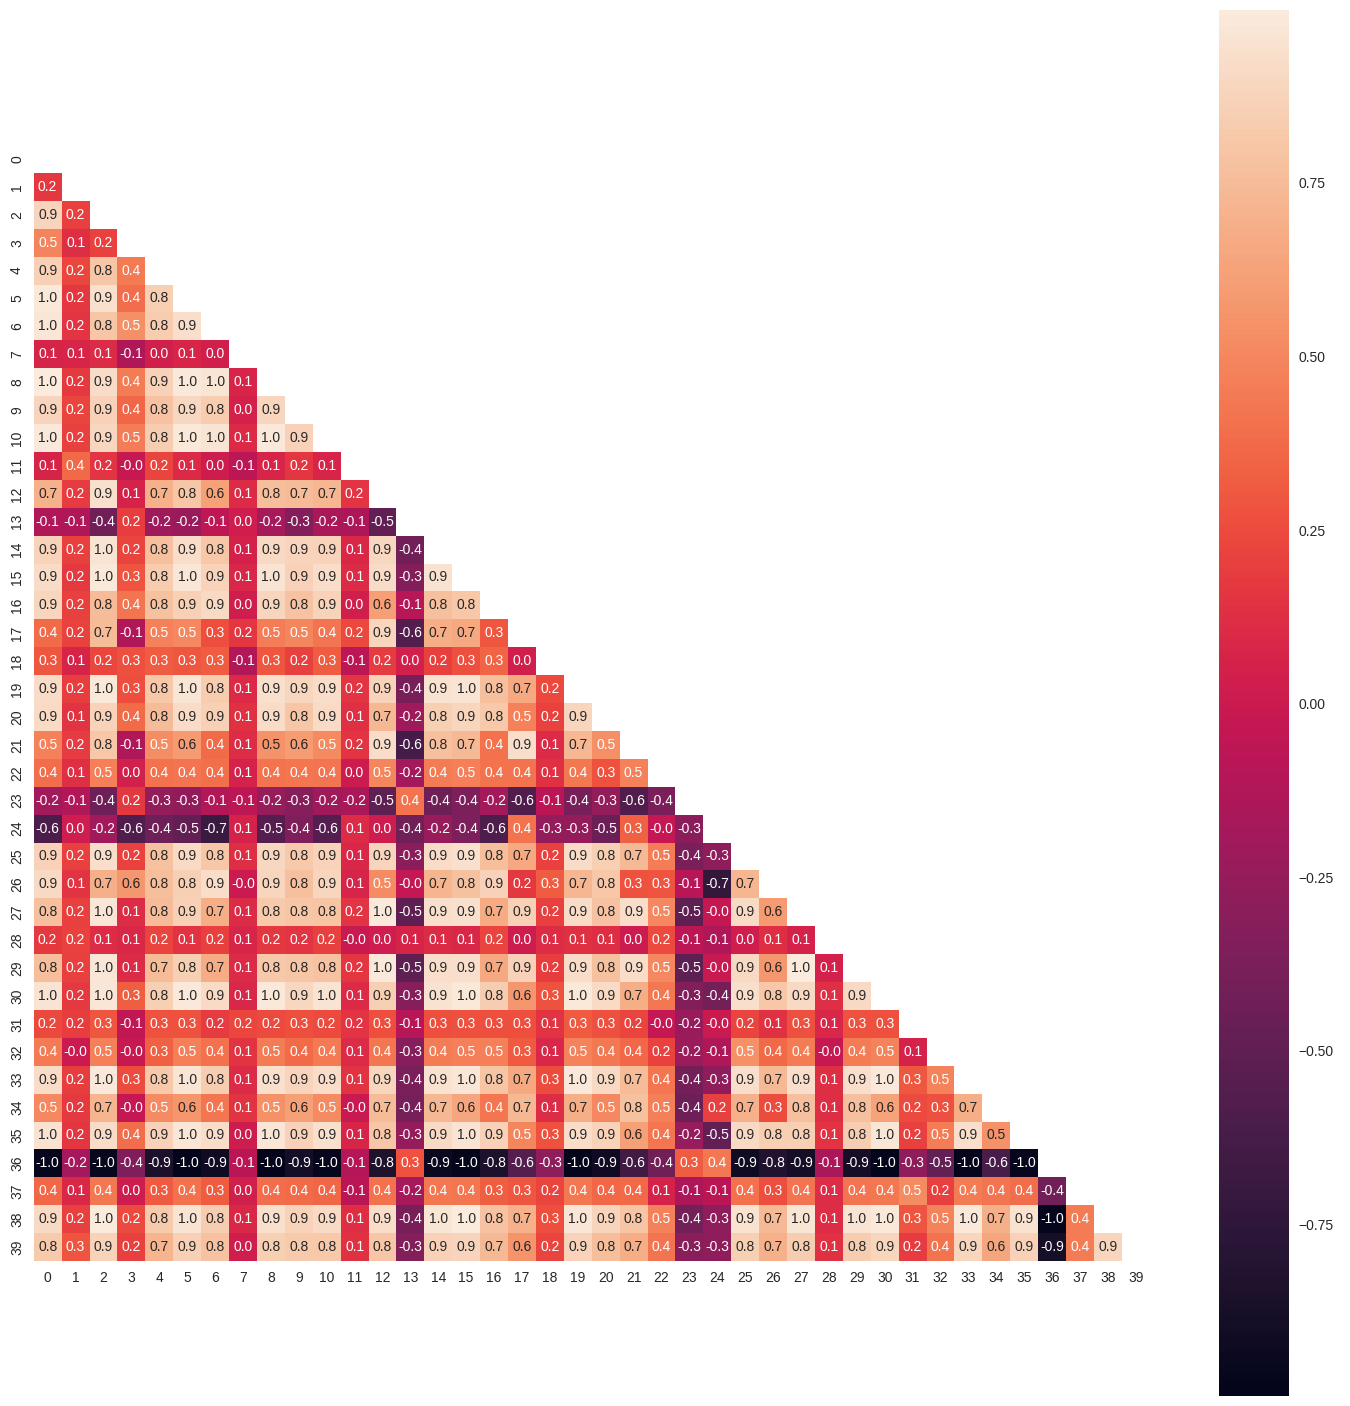

In [11]:
corr = np.corrcoef(X_train[54], rowvar=True)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(18, 18))
    ax = sns.heatmap(corr, mask=mask, annot=True, fmt='.1f', square=True)

Видна большая корреляция между датчиками, что логично. Деление на классы динамики волн поможет нам ее снизить.

### Регулировка данных

Создадим регулятор повышения/понижения границ определения динамики волны

In [12]:
def reg(step_inc=0, step_dec=0, noise=0) -> object:
    """Регулятор повышения/понижения границ определения динамики волны

    Args:
        step_inc (int, optional): регулеровка повышения волны. Defaults to 0.
        step_dec (int, optional): регулеровка понижения волны. Defaults to 0.
        noise (int, optional): регулеровка уровня шума. Defaults to 0.

    Returns:
        object: DataFrame основанный на нашей регулизации определения динамики волны
    """
    df = pd.DataFrame(data = np.nan, index = [x for x in range(X_train.shape[0])],
                 columns = ['sensor_'+ str(y + 1) for y in range(X_train.shape[1])], dtype = object)
    for i in range(len(X_train)):
        for j in range(len(X_train[i])):
            arr = (X_train[i][j])
            if (arr[0]-arr[-1]) < -350 + step_inc:
                df.iloc[i][j] = "pow+"
            elif (arr[0]-arr[-1]) > 350 + step_dec:
                df.iloc[i][j] = "pow-"
            elif abs(arr[0]-arr[-1]) < 150 + noise:
                df.iloc[i][j] = "noise"
            else:
                df.iloc[i][j] = "dr"
    
    return df

Создадим быструю проверку наших значений на логистической регресии

In [13]:
def test(data: pd.DataFrame, return_report=False) -> str:
    """функция возращает метрику accuracy основанной на нашем датасете(созданным регулятором),
    построенной на базовой логистической модели

    Args:
        data (pd.DataFrame): _description_
        return_report (bool, optional): _description_. Defaults to False.

    Returns:
        str: метрику accuracy
    """
    kf = KFold(n_splits=5)
    df_std = OneHotEncoder(sparse = False).fit_transform(data.values)

    model = LogisticRegression(max_iter=1000, penalty="l2", solver= "lbfgs", random_state=100)

    scores = cross_validate(
        estimator=model,
        X=df_std,
        y=y_train,
        scoring='f1_weighted',
        return_train_score=True,
        cv=kf)

    return [scores['train_score'].mean(), scores['test_score'].mean()]

Создадим 20 шагов регулировки для опреления повышения/понижения волны и определения шума. Также построим модели на данных значениях

In [14]:
f1_score_list = []
step_inc_list = np.linspace(-300, 300, 20)
step_dec_list = np.linspace(-300, 300, 20)
noise_list = np.linspace(-100, 100, 20)

for i in range(20):
    df = reg(step_inc= step_inc_list[i], step_dec=step_dec_list[i], noise=noise_list[i])
    f1_score_list.append(test(df))

/home/ya/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/ya/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/ya/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/ya/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed 

Построим график для определения лучших значений для модели

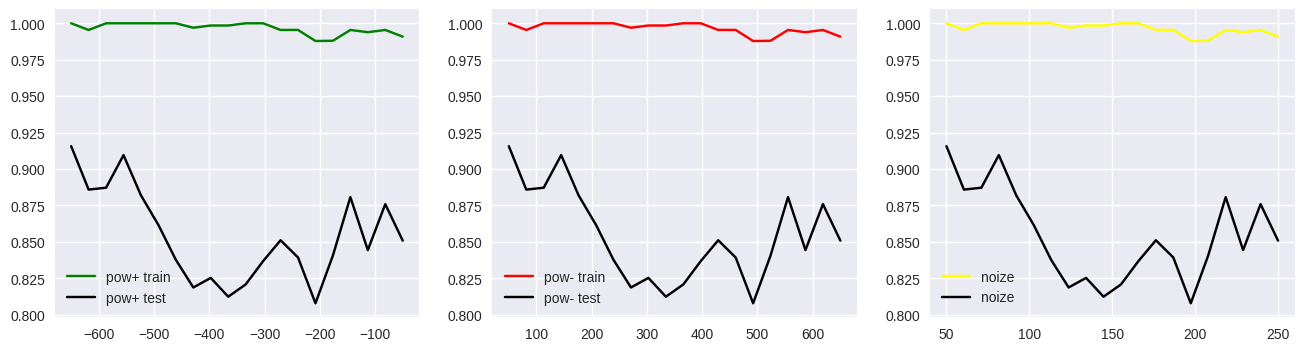

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

sns.lineplot(x=[i - 350 for i in step_inc_list], y=[x[0] for x in f1_score_list], ax=axes[0], color='green', label='pow+ train')
sns.lineplot(x=[i - 350 for i in step_inc_list], y=[x[1] for x in f1_score_list], ax=axes[0], color='black', label='pow+ test')
sns.lineplot(x=[i + 350 for i in step_dec_list], y=[x[0] for x in f1_score_list], ax=axes[1], color='red', label='pow- train')
sns.lineplot(x=[i + 350 for i in step_dec_list], y=[x[1] for x in f1_score_list], ax=axes[1], color='black', label='pow- test')
sns.lineplot(x=[i + 150 for i in noise_list], y=[x[0] for x in f1_score_list], ax=axes[2], color='yellow', label='noize')
sns.lineplot(x=[i + 150 for i in noise_list], y=[x[1] for x in f1_score_list], ax=axes[2], color='black', label='noize');

Видно что диаграммы прохожи. Поэтому придется регулировать каждый уровень по отдельности

In [16]:
f1_list_up, f1_list_down, f1_list_n = [], [], []

step_inc_list = np.linspace(-500, 500, 20)
step_dec_list = np.linspace(-500, 500, 20)
noise_list = np.linspace(0, 200, 20)

In [17]:
for i in range(20):
    df = reg(step_inc= step_inc_list[i])
    f1_list_up.append(test(df))

for i in range(20):
    df = reg(step_dec=step_dec_list[i])
    f1_list_down.append(test(df))

for i in range(20):
    df = reg(noise=noise_list[i])
    f1_list_n.append(test(df))

/home/ya/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/ya/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/ya/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/ya/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed 

Выведем наши результаты

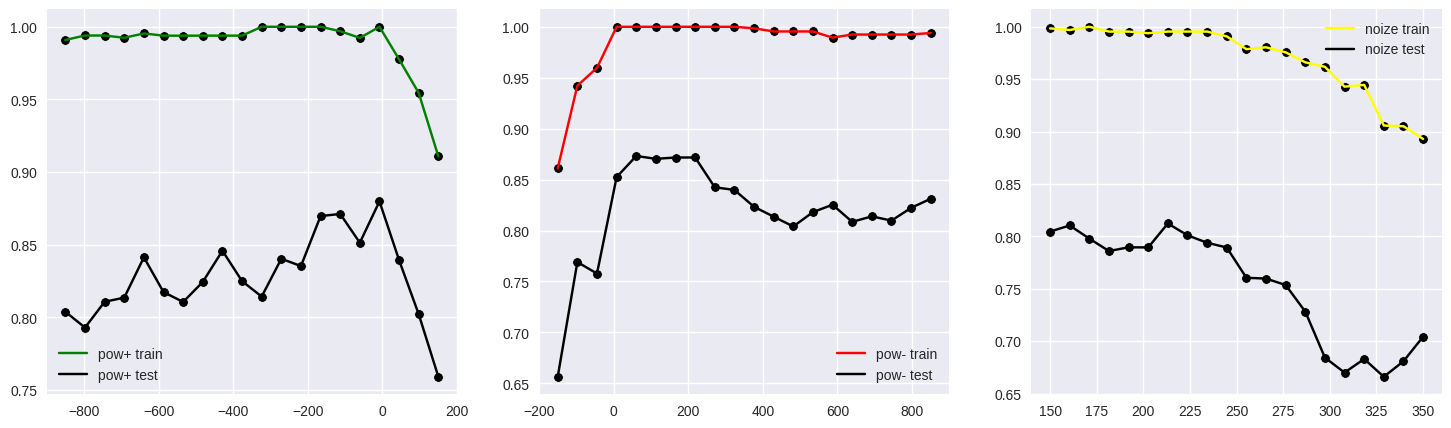

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.lineplot(x=[-350 + i for i in step_inc_list], y=[x[0] for x in f1_list_up], ax=axes[0], color='green', label='pow+ train')
sns.scatterplot(x=[-350 + i for i in step_inc_list], y=[x[0] for x in f1_list_up], ax=axes[0], color='black')
sns.lineplot(x=[-350 + i for i in step_inc_list], y=[x[1] for x in f1_list_up], ax=axes[0], color='black', label='pow+ test')
sns.scatterplot(x=[-350 + i for i in step_inc_list], y=[x[1] for x in f1_list_up], ax=axes[0], color='black')

sns.lineplot(x=[350 + i for i in step_dec_list], y=[x[0] for x in f1_list_down], ax=axes[1], color='red', label='pow- train')
sns.scatterplot(x=[350 + i for i in step_dec_list], y=[x[0] for x in f1_list_down], ax=axes[1], color='black')
sns.lineplot(x=[350 + i for i in step_dec_list], y=[x[1] for x in f1_list_down], ax=axes[1], color='black', label='pow- test')
sns.scatterplot(x=[350 + i for i in step_dec_list], y=[x[1] for x in f1_list_down], ax=axes[1], color='black')

sns.lineplot(x=[i + 150 for i in noise_list], y=[x[0] for x in f1_list_n], ax=axes[2], color='yellow', label='noize train')
sns.scatterplot(x=[i + 150 for i in noise_list], y=[x[0] for x in f1_list_n], ax=axes[2], color='black')
sns.lineplot(x=[i + 150 for i in noise_list], y=[x[1] for x in f1_list_n], ax=axes[2], color='black', label='noize test')
sns.scatterplot(x=[i + 150 for i in noise_list], y=[x[1] for x in f1_list_n], ax=axes[2], color='black');

In [20]:
print(f'Лучшие значеня нойза: +{noise_list[6].round()}')

Лучшие значеня нойза: +63.0


In [21]:
print(f'Лучшие значеня при повышении уровня: +{step_inc_list[16].round()}')

Лучшие значеня при повышении уровня: +342.0


In [23]:
print(f'Лучшие значеня при повышении уровня: {step_inc_list[4].round()}')

Лучшие значеня при повышении уровня: -289.0


Возьмем лучщие значения и обучим на них модель

In [24]:
final_acc_list = []

df = reg(step_inc=342, step_dec=-289, noise=63)
scores = test(df)

/home/ya/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [25]:
scores

[0.9954102427786639, 0.8343867243867245]

Построим модель на наших лучших значениях

### Преобразование новых данных

Преобразуем два датасета(X_train, X_test) на основе наших лучших значений 

In [26]:
df = pd.DataFrame(data = np.nan, index = [x for x in range(X_train.shape[0])],
            columns = ['sensor_'+ str(y + 1) for y in range(X_train.shape[1])], dtype = object)
for i in range(len(X_train)):
    for j in range(len(X_train[i])):
        arr = (X_train[i][j])
        if (arr[0]-arr[-1]) < -350 + 342:
            df.iloc[i][j] = "pow+"
        elif (arr[0]-arr[-1]) > 350 - 289:
             df.iloc[i][j] = "pow-"
        elif abs(arr[0]-arr[-1]) < 150 + 63:
                df.iloc[i][j] = "noise"
        else:
            df.iloc[i][j] = "dr"

df_test = pd.DataFrame(data = np.nan, index = [x for x in range(X_test.shape[0])],
            columns = ['sensor_'+ str(y + 1) for y in range(X_test.shape[1])], dtype = object)
for i in range(len(X_test)):
    for j in range(len(X_test[i])):
        arr = (X_test[i][j])
        if (arr[0]-arr[-1]) < -350 + 342:
            df_test.iloc[i][j] = "pow+"
        elif (arr[0]-arr[-1]) > 350 - 289:
             df_test.iloc[i][j] = "pow-"
        elif abs(arr[0]-arr[-1]) < 150 + 63:
                df_test.iloc[i][j] = "noise"
        else:
            df_test.iloc[i][j] = "dr"

In [27]:
df.head(8)

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40
0,pow-,noise,pow-,noise,noise,pow-,noise,noise,pow-,noise,...,pow-,noise,noise,pow+,noise,noise,pow+,noise,pow+,noise
1,pow+,noise,pow+,noise,pow+,pow+,noise,noise,noise,noise,...,pow+,noise,noise,noise,pow+,noise,pow-,noise,noise,noise
2,pow+,pow+,pow+,pow+,pow+,pow+,noise,noise,pow+,pow+,...,pow+,noise,noise,noise,noise,noise,pow-,noise,pow+,noise
3,pow-,noise,pow+,pow+,noise,pow-,noise,noise,pow-,noise,...,pow+,noise,noise,noise,noise,noise,pow-,noise,pow+,noise
4,pow+,noise,pow-,pow+,noise,pow-,pow+,noise,pow+,noise,...,pow+,noise,noise,pow+,noise,pow+,pow-,pow+,pow+,noise
5,pow+,noise,pow+,noise,noise,pow+,noise,noise,noise,noise,...,pow+,noise,noise,pow-,noise,noise,pow-,noise,pow-,noise
6,noise,noise,pow-,noise,noise,pow+,noise,noise,pow-,noise,...,pow-,noise,noise,pow-,noise,noise,pow+,noise,pow-,noise
7,pow+,pow+,pow+,noise,noise,pow+,noise,noise,pow+,noise,...,pow+,noise,noise,pow+,noise,noise,pow+,noise,pow+,noise


### Кодирование

In [29]:
df_std = OneHotEncoder(sparse_output = False).fit_transform(df.values)
df_std_test = OneHotEncoder(sparse_output = False).fit_transform(df_test.values)

In [30]:
print(f'Shape of train:{df_std.shape} / Shape of test:{df_std_test.shape}')

Shape of train:(165, 96) / Shape of test:(166, 99)


Как можно заметить, кодировщик создал неодинаковое количество признаков. Логистическая регрессия не сможет предсказать X_test. Поэтому можно воспользоваться методом главных компонентов PCA, он выделит одинаковое количетсво важных признаков как для X_train, так для и X_test

In [31]:
#для X_train
pca = PCA(n_components=80)
pca_data = pca.fit_transform(df_std)

In [32]:
#для X_test
pca = PCA(n_components=80)
pca_data_test = pca.fit_transform(df_std_test)

### Построение модели

Сначала посмотрим как модель обучилась на тренировочной выборке 

In [35]:
model = LogisticRegressionCV(max_iter=1000, cv=5, penalty="l2", solver= "lbfgs", random_state=100)

model.fit(pca_data, y_train)
y_predict = model.predict(pca_data)

score = f1_score(y_predict, y_train, average='weighted')
scores = classification_report(y_predict, y_train, zero_division=1)
print(f'F1 score is {score}')
print(scores)

F1 score is 0.9939545834282676
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.90      1.00      0.95         9
           2       1.00      1.00      1.00        10
           3       1.00      0.91      0.95        11
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        11
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        11
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        10
          15       1.00      1.00      1.00        11

    accuracy                           0.99      

Модель справилась отлично. Теперь можно предсказать и для тестовой выборки

In [36]:
model.fit(pca_data, y_train)
y_predict_test = model.predict(pca_data_test)

sub = pd.read_csv('data/sample_submission.csv')
sub['Class'] = y_predict_test
with open(f"data/result.csv", "w") as file:
    sub.to_csv(file, index=False)

<img src='data/kaggle.png'>

К сожалению наша модель переобучилась, попробуем другой подход к преобразованию данных

Поробуем на основании процентного соотношения

In [38]:
df = (X_train[:, :, 0] - X_train[:, :, -1] + 1) / (X_train[:, :, 0] + 1)
df_test = (X_test[:, :, 0] - X_test[:, :, -1] + 1) / (X_test[:, :, 0] + 1)

for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if df[i, j] < -0.1:
            df[i, j] = -1
        elif df[i, j] > 0.1:
            df[i, j] = +1
        else:
            df[i, j] = 0

for i in range(df_test.shape[0]):
    for j in range(df_test.shape[1]):
        if df_test[i, j] < -0.1:
            df_test[i, j] = -1
        elif df_test[i, j] > 0.1:
            df_test[i, j] = +1
        else:
            df_test[i, j] = 0

In [44]:
model = LogisticRegressionCV(max_iter=1000, cv=5, penalty="l2", solver= "lbfgs", random_state=100)

model.fit(df, y_train)
y_predict = model.predict(df)
y_predict_test = model.predict(df_test)

scores = classification_report(y_predict, y_train, zero_division=1)
print(f'F1 score is {score}')
print(scores)

F1 score is 0.9939545834282676
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        10
           2       1.00      0.91      0.95        11
           3       0.90      1.00      0.95         9
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        11
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        11
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        10
          15       1.00      1.00      1.00        11

    accuracy                           0.99      

In [45]:
sub = pd.read_csv('data/sample_submission.csv')
sub['Class'] = y_predict_test
with open(f"data/result2.csv", "w") as file:
    sub.to_csv(file, index=False)

<img src='data/kaggle2.png'>

Данный подход показал себя намного лучше